In [12]:
import os 
import datetime 
#打印时间 
def printbar():    
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')    
    print("\n"+"=========="*8 + "%s"%nowtime) 
    #mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量 
    os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

In [1]:
# Pytorch的层次结构从低到高可以分成如下五层。 

# 最底层为硬件层，Pytorch支持CPU、GPU加入计算资源池。 

# 第二层为C++实现的内核。

# 第三层为Python实现的操作符，
# 提供了封装C++内核的低级API指令，
# 主要包括各种张量操作算子、自动微分、变量管理. 
# 如torch.tensor,torch.cat,torch.autograd.grad,nn.Module. 
# 如果把模型 比作一个房子，那么第三层API就是【模型之砖】。

# 第四层为Python实现的模型组件，对低级API进行了函数封装，
# 主要包括各种模型层，损失函数，优化器，数据管道等等。 
# 如 torch.nn.Linear,torch.nn.BCE,torch.optim.Adam,torch.utils.data.DataLoader. 
# 如果把模型比作一 个房子，那么第四层API就是【模型之墙】。

# 第五层为Python实现的模型接口。Pytorch没有官方的高阶API。
# 为了便于训练模型，仿照 keras中的模型接口，
# 使用了不到300行代码，封装了Pytorch的高阶模型接口
# torchkeras.Model。
# 如果把模型比作一个房子，那么第五层API就是模型本身，即【模型之屋】。

In [3]:
# 一、线性回归模型

# 1. 准备数据

import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd
from torch import nn

# 样本数量
n = 400

# 生成测试用数据集

X = 10*torch.rand([n,2]) - 5.0 #torch.rand是均匀分布
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal(0.0,2.0,size = [n,1])
# @表示矩阵乘法，增加动态扰动

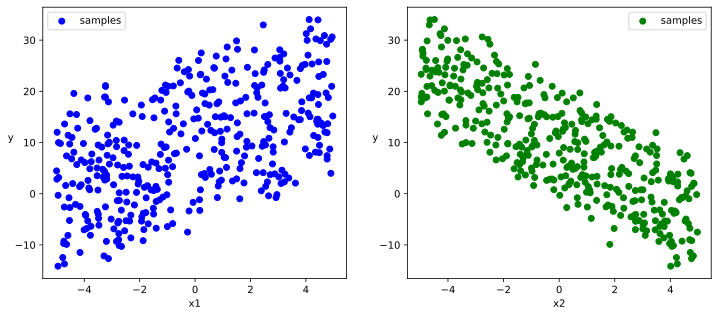

In [4]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(),c = "b", label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(),c = "g", label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [5]:
# 构建数据管道迭代器

def data_iter(features, labels, batcj_size = 8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  # 随机顺序读取样本
    
    for i in range(0,num_examples,batch_size):
        indexs = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,indexs),labels.index_select(0,indexs)
        
# 测试数据管道效果

batch_size = 8
(features, labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tensor([[ 0.3526, -2.0985],
        [-0.9688, -3.7371],
        [ 2.4630, -4.6714],
        [ 1.0522,  1.2733],
        [-3.3185, -1.4787],
        [ 2.5295, -1.1739],
        [-1.4491, -3.6434],
        [-3.1922, -1.2133]])
tensor([[19.4706],
        [20.9767],
        [32.9644],
        [ 7.0975],
        [ 3.2582],
        [17.7209],
        [18.7019],
        [ 3.6504]])


In [6]:
# 2. 定义模型

class LinearRegression:
    def __init__(self):
        self.w = torch.randn_like(w0,requires_grad = True)
        self.b = torch.zeros_like(b0,requires_grad = True)
    
#     正向传播
    def forward(self,x):
        return x@self.w + self.b
    
#     损失函数
    def loss_func(self,y_pred,y_true):
        return torch.mean((y_pred - y_true)**2/2)
    
model = LinearRegression()

In [15]:
# 3. 训练模型

def train_step(model, features, labels):
    predictions = model.forward(features)
    loss = model.loss_func(predictions, labels)
    
    loss.backward()
    
     # 使用torch.no_grad()避免梯度记录，也可以通过操作 model.w.data 实现避免梯度记录 
    with torch.no_grad():
        model.w -= 0.001*model.w.grad
        model.b -= 0.001*model.b.grad
        
#         梯度清零
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss

In [18]:
# 测试train_step的效果
batch_size = 10
(features, labels) = next(data_iter(X,Y,batch_size))
train_step(model, features, labels)

tensor(1.2254, grad_fn=<MeanBackward0>)

In [20]:
def train_model(model, epochs):
    for epoch in range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model, features, labels)
        if epoch%200 == 0 :
            printbar()
            print("epoch = " ,epoch, "loss = ", loss.item())
            print("model_w = ", model.w.data)
            print("model_b = ", model.b.data)
train_model(model, epochs = 1000)


================================================================================2021-09-27 09:04:54
epoch =  200 loss =  3.608628749847412
model_w =  tensor([[ 2.0126],
        [-3.0173]])
model_b =  tensor([[10.0531]])

================================================================================2021-09-27 09:04:56
epoch =  400 loss =  1.3911758661270142
model_w =  tensor([[ 2.0125],
        [-3.0176]])
model_b =  tensor([[10.0532]])

================================================================================2021-09-27 09:04:57
epoch =  600 loss =  1.208569884300232
model_w =  tensor([[ 2.0123],
        [-3.0183]])
model_b =  tensor([[10.0534]])

================================================================================2021-09-27 09:04:58
epoch =  800 loss =  1.718549370765686
model_w =  tensor([[ 2.0101],
        [-3.0179]])
model_b =  tensor([[10.0533]])

================================================================================2021-09-27 09:05:00
epoch =  1000 

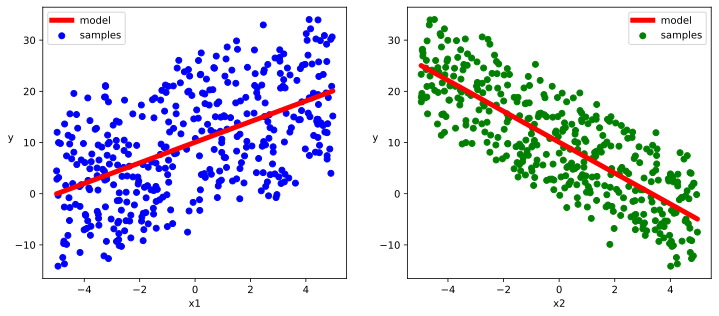

In [21]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12,5))

ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.plot(X[:,0].numpy(),(model.w[0].data*X[:,0]+model.b[0].data).numpy(),"r",linewidth = 5.0,label = "model") 
ax1.legend() 
plt.xlabel("x1") 
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.plot(X[:,1].numpy(),(model.w[1].data*X[:,1]+model.b[0].data).numpy(),"r",linewidth = 5.0,label = "model")
ax2.legend() 
plt.xlabel("x2") 
plt.ylabel("y",rotation = 0)


plt.show()